# Genetic Algorithm Training System for AlphaGem

This notebook implements a natural selection/genetic algorithm approach to train AlphaGem models:
1. Start with a parent model
2. Create child models with slight variations (mutations)
3. Have models play each other in tournaments
4. Select the best performing model as the next parent
5. Repeat for multiple generations

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import copy
import sys
from tqdm import tqdm
import os
import time
# Add src to path to match run.py style
sys.path.insert(0, os.path.dirname(os.path.abspath('')))
from typing import List, Dict, Tuple
from app.alphagem.alpha_gem import AlphaGem
from app.competition import interface
from app.bots.alpha_gem_bot import AlphaGemBot
from app.competition.interface import PocketRocketsBot, Bid, GameObservation, AuctionResult, legal_max_bid
from app.competition.simulator import run_pocketrocks_simulation, BotEntry, SimulationResult


In [ ]:
# Training Configuration
NUM_GENERATIONS = 100
POPULATION_SIZE = 12  # Number of children per generation (including parent)
NUM_GAMES_PER_EVALUATION = 500  # Number of games to play for evaluation
MUTATION_RATE = 0.15  # Probability of mutating each parameter
MUTATION_STRENGTH = 0.05  # Standard deviation of mutation noise
NUM_PLAYERS = 3  # Players per game

# Create models directory if it doesn't exist
# Models will be saved in src/models/ directory
MODELS_DIR = os.path.join(os.getcwd(), 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

# Generate a timestamp for this training run
TIMESTAMP = int(time.time())
print(f"Training timestamp: {TIMESTAMP}")
print(f"Models will be saved to: {os.path.abspath(MODELS_DIR)}")

# Initialize parent model
parent_model = AlphaGem(num_players=NUM_PLAYERS)
parent_model.load_state_dict(torch.load("models/model_final_1767150966.pth"))

# Track training history
training_history = {
    'generations': [],
    'best_scores': [],
    'avg_scores': [],
    'parent_scores': [],
    'best_win_rates': [],  # Win rate of best model
    'parent_win_rates': [],  # Win rate of parent model
    'best_avg_ranks': [],  # Average rank of best model (lower is better)
    'parent_avg_ranks': [],  # Average rank of parent model
    'avg_win_rates': []  # Average win rate across all models
}


Training timestamp: 1767150966
Models will be saved to: c:\Users\austi\Desktop\pocketrockscompetition\src\models


In [2]:
def mutate_model(parent_model: AlphaGem, mutation_rate: float = 0.1, mutation_strength: float = 0.1) -> AlphaGem:
    """
    Create a mutated copy of the parent model.
    
    Args:
        parent_model: The parent model to mutate
        mutation_rate: Probability of mutating each parameter (0-1)
        mutation_strength: Standard deviation of Gaussian noise added to parameters
    
    Returns:
        A new AlphaGem model with mutations
    """
    # Create a deep copy
    child = AlphaGem(num_players=parent_model.num_players)
    child.load_state_dict(parent_model.state_dict())
    
    # Apply mutations to all parameters
    with torch.no_grad():
        for param in child.parameters():
            if param.requires_grad:
                # Create a mask for which parameters to mutate
                mask = torch.rand_like(param) < mutation_rate
                # Add Gaussian noise to selected parameters
                noise = torch.randn_like(param) * mutation_strength
                param.add_(mask * noise)
    
    return child

In [3]:
def create_generation(parent_model: AlphaGem, population_size: int, mutation_rate: float = 0.1, mutation_strength: float = 0.1) -> List[AlphaGem]:
    """
    Create a generation of child models from a parent.
    
    Args:
        parent_model: The parent model
        population_size: Number of children to create
        mutation_rate: Probability of mutating each parameter
        mutation_strength: Standard deviation of mutation noise
    
    Returns:
        List of child models (including the parent)
    """
    children = []
    # Include the parent in the generation
    parent_copy = AlphaGem(num_players=parent_model.num_players)
    parent_copy.load_state_dict(parent_model.state_dict())
    children.append(parent_copy)
    
    # Create mutated children
    for i in range(population_size - 1):
        child = mutate_model(parent_model, mutation_rate, mutation_strength)
        children.append(child)
    
    return children


In [22]:
def evaluate_models(models: List[AlphaGem], num_games: int = 50, num_players: int = 3) -> Tuple[Dict[int, float], Dict[int, Dict[str, float]]]:
    """
    Evaluate models by having them play against each other.
    
    Args:
        models: List of AlphaGem models to evaluate
        num_games: Number of games to play
        num_players: Number of players per game
    
    Returns:
        Tuple of:
        - Dictionary mapping model index to fitness score (for selection)
        - Dictionary mapping model index to detailed stats (win_rate, avg_rank, avg_score)
    """
    # Create bot entries for each model
    # Use a closure-safe approach by storing models in a list and using index
    bot_entries = []
    for i in range(len(models)):
        # Create a factory function that properly captures the model index
        def make_bot_factory(model_idx):
            def make_bot():
                # Create a fresh copy of the model for each game
                model_copy = AlphaGem(num_players=models[model_idx].num_players)
                model_copy.load_state_dict(models[model_idx].state_dict())
                return AlphaGemBot(model_copy, name=f"Model_{model_idx}")
            return make_bot
        
        bot_entries.append(BotEntry(f"Model_{i}", make_bot_factory(i)))
    
    # Run simulation
    result = run_pocketrocks_simulation(
        bot_entries,
        n_games=num_games,
        players_per_game=num_players,
        seed=random.randint(0, 1000000)
    )
    
    # Extract fitness scores and detailed stats for each model
    scores = {}
    detailed_stats = {}
    
    for i in range(len(models)):
        model_name = f"Model_{i}"
        if model_name in result.per_bot:
            stats = result.per_bot[model_name]
            if stats.games > 0:
                win_rate = stats.wins / stats.games
                avg_rank = sum(stats.ranks) / stats.games if stats.ranks else num_players
                avg_score = stats.total_score / stats.games
                
                # Use composite fitness: win rate (50%) + rank (30%) + normalized score (20%)
                # For rank: lower is better, so use 1/rank (best rank=1 gives 1.0, worst gives 1/num_players)
                normalized_rank = 1.0 / avg_rank if avg_rank > 0 else 0.0
                
                # For score normalization, we'll use a simple approach
                # In practice, scores vary, so we'll normalize relative to the range
                # For now, use win rate as primary metric with rank as secondary
                fitness = (0.6 * win_rate) + (0.4 * normalized_rank)
                
                scores[i] = fitness
                detailed_stats[i] = {
                    'win_rate': win_rate,
                    'avg_rank': avg_rank,
                    'avg_score': avg_score,
                    'wins': stats.wins,
                    'games': stats.games
                }
            else:
                scores[i] = 0.0
                detailed_stats[i] = {
                    'win_rate': 0.0,
                    'avg_rank': num_players,
                    'avg_score': 0.0,
                    'wins': 0,
                    'games': 0
                }
        else:
            scores[i] = 0.0
            detailed_stats[i] = {
                'win_rate': 0.0,
                'avg_rank': num_players,
                'avg_score': 0.0,
                'wins': 0,
                'games': 0
            }
    
    return scores, detailed_stats

In [ ]:
# Main Training Loop
print("Starting Genetic Algorithm Training...")
print(f"Generations: {NUM_GENERATIONS}, Population: {POPULATION_SIZE}, Games per eval: {NUM_GAMES_PER_EVALUATION}")
print("-" * 60)

for generation in tqdm(range(NUM_GENERATIONS), desc="Training Progress"):
    print(f"\n=== Generation {generation + 1}/{NUM_GENERATIONS} ===")
    
    # Create generation from parent
    print("Creating generation...")
    generation_models = create_generation(
        parent_model, 
        population_size=POPULATION_SIZE,
        mutation_rate=MUTATION_RATE,
        mutation_strength=MUTATION_STRENGTH
    )
    
    # Evaluate all models
    print(f"Evaluating {len(generation_models)} models over {NUM_GAMES_PER_EVALUATION} games...")
    scores, detailed_stats = evaluate_models(
        generation_models, 
        num_games=NUM_GAMES_PER_EVALUATION,
        num_players=NUM_PLAYERS
    )
    
    # Find best model
    best_idx = max(scores.keys(), key=lambda k: scores[k])
    best_score = scores[best_idx]
    parent_score = scores[0]  # Parent is always index 0
    
    # Get competitive statistics
    best_stats = detailed_stats[best_idx]
    parent_stats = detailed_stats[0]
    
    # Calculate average win rate across all models
    avg_win_rate = np.mean([stats['win_rate'] for stats in detailed_stats.values()])
    
    # Update parent to best model
    parent_model = generation_models[best_idx]
    
    # Track history
    training_history['generations'].append(generation + 1)
    training_history['best_scores'].append(best_score)
    training_history['parent_scores'].append(parent_score)
    training_history['avg_scores'].append(np.mean(list(scores.values())))
    training_history['best_win_rates'].append(best_stats['win_rate'])
    training_history['parent_win_rates'].append(parent_stats['win_rate'])
    training_history['best_avg_ranks'].append(best_stats['avg_rank'])
    training_history['parent_avg_ranks'].append(parent_stats['avg_rank'])
    training_history['avg_win_rates'].append(avg_win_rate)
    
    # Print results with competitive metrics
    print(f"Best model: Model_{best_idx}")
    print(f"  Fitness: {best_score:.4f} | Win Rate: {best_stats['win_rate']*100:.1f}% ({best_stats['wins']}/{best_stats['games']}) | Avg Rank: {best_stats['avg_rank']:.2f} | Avg Score: {best_stats['avg_score']:.2f}")
    print(f"Parent model:")
    print(f"  Fitness: {parent_score:.4f} | Win Rate: {parent_stats['win_rate']*100:.1f}% ({parent_stats['wins']}/{parent_stats['games']}) | Avg Rank: {parent_stats['avg_rank']:.2f} | Avg Score: {parent_stats['avg_score']:.2f}")
    print(f"Population average win rate: {avg_win_rate*100:.1f}%")
    print(f"Fitness improvement: {best_score - parent_score:+.4f}")
    print(f"Win rate improvement: {(best_stats['win_rate'] - parent_stats['win_rate'])*100:+.1f}%")
    
    # Save best model periodically
    if (generation + 1) % 5 == 0:
        model_path = os.path.join(MODELS_DIR, f"model_gen_{generation + 1}_{TIMESTAMP}.pth")
        torch.save(parent_model.state_dict(), model_path)
        print(f"Saved model to {model_path}")

print("\n" + "=" * 60)
print("Training Complete!")
print(f"Final best score: {training_history['best_scores'][-1]:.2f}")

# Save final model
final_model_path = os.path.join(MODELS_DIR, f"model_final_{TIMESTAMP}.pth")
torch.save(parent_model.state_dict(), final_model_path)
print(f"Saved final model to {final_model_path}")


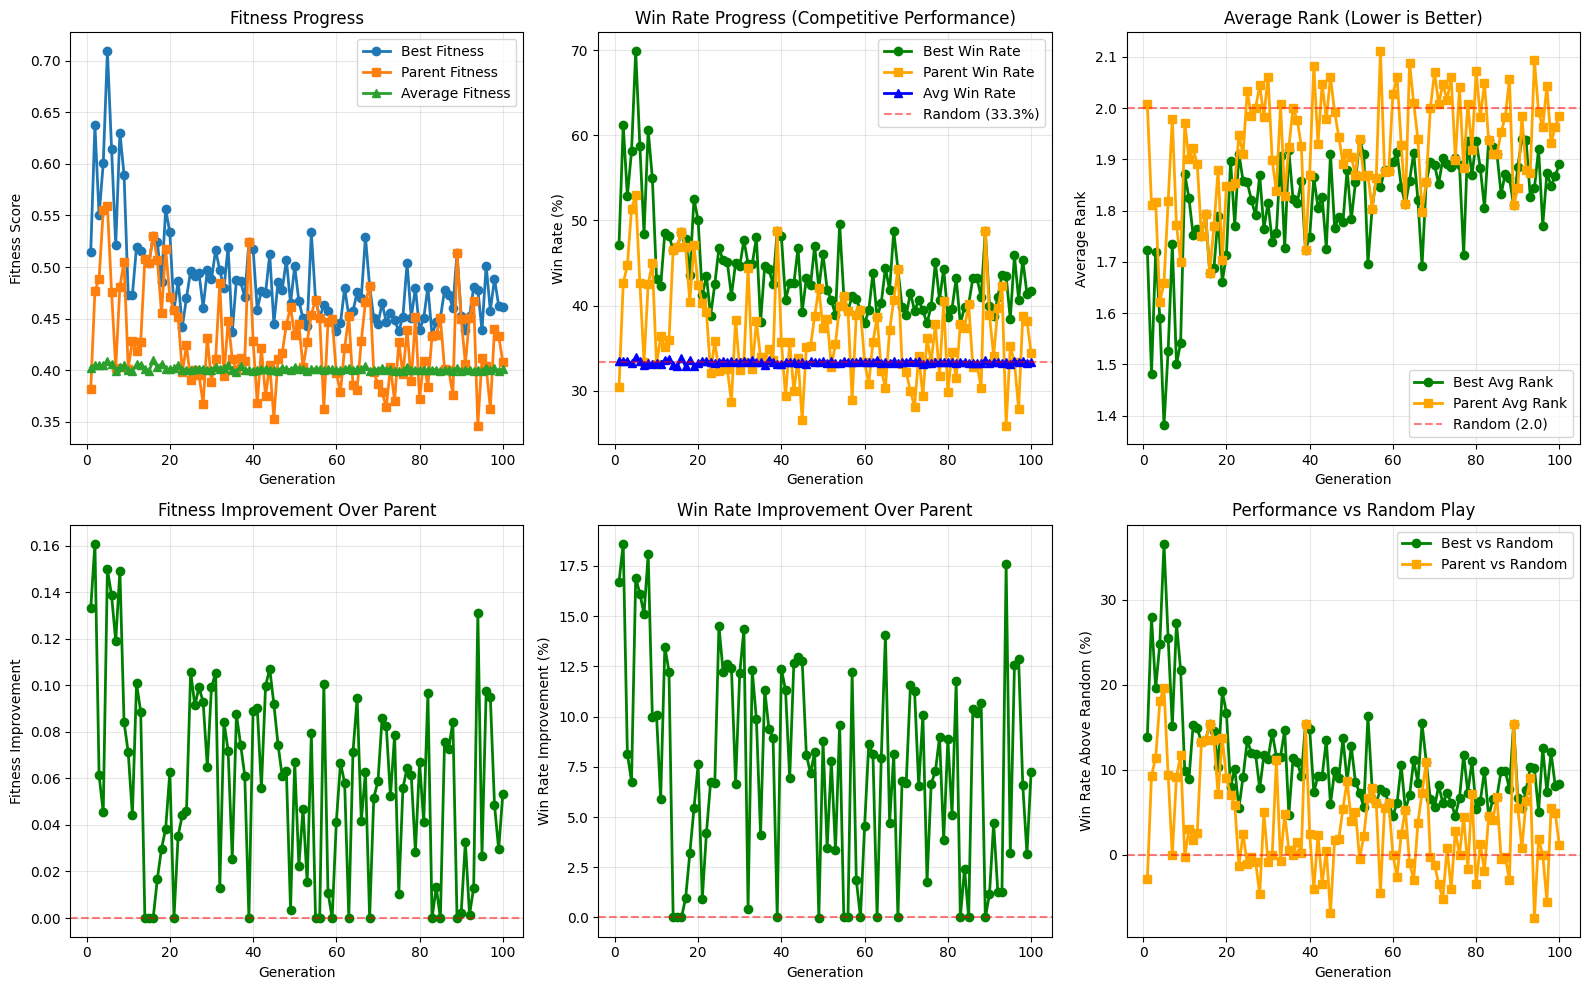


Training Statistics:

Fitness Metrics:
  Best fitness achieved: 0.7092
  Final fitness: 0.4615
  Total fitness improvement: -0.0535

Competitive Performance (Win Rates):
  Best win rate achieved: 69.9%
  Final best win rate: 41.7%
  Final parent win rate: 34.4%
  Expected random win rate: 33.3%
  Best improvement over random: +36.6%
  Final improvement over random: +8.3%

Rank Metrics (Lower is Better):
  Best average rank achieved: 1.38
  Final best average rank: 1.89
  Final parent average rank: 1.98
  Expected random rank: 2.00
  Best improvement over random: +0.62 ranks better


In [7]:
# Plot Training Progress
plt.figure(figsize=(16, 10))

# Plot 1: Fitness scores
plt.subplot(2, 3, 1)
plt.plot(training_history['generations'], training_history['best_scores'], 'o-', label='Best Fitness', linewidth=2)
plt.plot(training_history['generations'], training_history['parent_scores'], 's-', label='Parent Fitness', linewidth=2)
plt.plot(training_history['generations'], training_history['avg_scores'], '^-', label='Average Fitness', linewidth=2)
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.title('Fitness Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Win Rates (most important competitive metric)
plt.subplot(2, 3, 2)
plt.plot(training_history['generations'], [wr*100 for wr in training_history['best_win_rates']], 'o-', label='Best Win Rate', linewidth=2, color='green')
plt.plot(training_history['generations'], [wr*100 for wr in training_history['parent_win_rates']], 's-', label='Parent Win Rate', linewidth=2, color='orange')
plt.plot(training_history['generations'], [wr*100 for wr in training_history['avg_win_rates']], '^-', label='Avg Win Rate', linewidth=2, color='blue')
# Add expected win rate line (1/num_players for random play)
expected_win_rate = 100.0 / NUM_PLAYERS
plt.axhline(y=expected_win_rate, color='r', linestyle='--', alpha=0.5, label=f'Random ({expected_win_rate:.1f}%)')
plt.xlabel('Generation')
plt.ylabel('Win Rate (%)')
plt.title('Win Rate Progress (Competitive Performance)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Average Ranks (lower is better)
plt.subplot(2, 3, 3)
plt.plot(training_history['generations'], training_history['best_avg_ranks'], 'o-', label='Best Avg Rank', linewidth=2, color='green')
plt.plot(training_history['generations'], training_history['parent_avg_ranks'], 's-', label='Parent Avg Rank', linewidth=2, color='orange')
# Add expected rank line (average of 1,2,3 = 2.0 for 3 players)
expected_rank = (NUM_PLAYERS + 1) / 2.0
plt.axhline(y=expected_rank, color='r', linestyle='--', alpha=0.5, label=f'Random ({expected_rank:.1f})')
plt.xlabel('Generation')
plt.ylabel('Average Rank')
plt.title('Average Rank (Lower is Better)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Fitness Improvement
plt.subplot(2, 3, 4)
improvements = [best - parent for best, parent in zip(training_history['best_scores'], training_history['parent_scores'])]
plt.plot(training_history['generations'], improvements, 'o-', color='green', linewidth=2)
plt.xlabel('Generation')
plt.ylabel('Fitness Improvement')
plt.title('Fitness Improvement Over Parent')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot 5: Win Rate Improvement
plt.subplot(2, 3, 5)
win_rate_improvements = [(best - parent)*100 for best, parent in zip(training_history['best_win_rates'], training_history['parent_win_rates'])]
plt.plot(training_history['generations'], win_rate_improvements, 'o-', color='green', linewidth=2)
plt.xlabel('Generation')
plt.ylabel('Win Rate Improvement (%)')
plt.title('Win Rate Improvement Over Parent')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot 6: Win Rate vs Expected (shows if better than random)
plt.subplot(2, 3, 6)
best_above_random = [(wr - expected_win_rate/100)*100 for wr in training_history['best_win_rates']]
parent_above_random = [(wr - expected_win_rate/100)*100 for wr in training_history['parent_win_rates']]
plt.plot(training_history['generations'], best_above_random, 'o-', label='Best vs Random', linewidth=2, color='green')
plt.plot(training_history['generations'], parent_above_random, 's-', label='Parent vs Random', linewidth=2, color='orange')
plt.xlabel('Generation')
plt.ylabel('Win Rate Above Random (%)')
plt.title('Performance vs Random Play')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Training Statistics:")
print("="*60)
print(f"\nFitness Metrics:")
print(f"  Best fitness achieved: {max(training_history['best_scores']):.4f}")
print(f"  Final fitness: {training_history['best_scores'][-1]:.4f}")
print(f"  Total fitness improvement: {training_history['best_scores'][-1] - training_history['best_scores'][0]:+.4f}")

print(f"\nCompetitive Performance (Win Rates):")
print(f"  Best win rate achieved: {max(training_history['best_win_rates'])*100:.1f}%")
print(f"  Final best win rate: {training_history['best_win_rates'][-1]*100:.1f}%")
print(f"  Final parent win rate: {training_history['parent_win_rates'][-1]*100:.1f}%")
print(f"  Expected random win rate: {expected_win_rate:.1f}%")
print(f"  Best improvement over random: {(max(training_history['best_win_rates']) - expected_win_rate/100)*100:+.1f}%")
print(f"  Final improvement over random: {(training_history['best_win_rates'][-1] - expected_win_rate/100)*100:+.1f}%")

print(f"\nRank Metrics (Lower is Better):")
print(f"  Best average rank achieved: {min(training_history['best_avg_ranks']):.2f}")
print(f"  Final best average rank: {training_history['best_avg_ranks'][-1]:.2f}")
print(f"  Final parent average rank: {training_history['parent_avg_ranks'][-1]:.2f}")
print(f"  Expected random rank: {expected_rank:.2f}")
print(f"  Best improvement over random: {expected_rank - min(training_history['best_avg_ranks']):+.2f} ranks better")


In [12]:
# Detailed Single Game Simulation with Omniscient Observer Logging
def simulate_and_log_game(model_paths: List[str] = None, num_players: int = 3, seed: int = None):
    """
    Simulate a single game with detailed logging from an omniscient observer perspective.
    Shows all hidden information including unrevealed cards and gem values.
    
    Args:
        model_paths: List of model file paths to load (e.g., ["models/model_gen_5_123.pth", "models/model_gen_10_123.pth"])
                    If None or fewer paths than num_players, fills remaining with random models.
                    If a path is None, uses a random model for that position.
        num_players: Number of players (3-5)
        seed: Random seed for reproducibility
    
    Example:
        # Compare generation 5 vs generation 10 vs generation 20
        simulate_and_log_game(
            model_paths=["models/model_gen_5_1767150966.pth", 
                        "models/model_gen_10_1767150966.pth",
                        "models/model_gen_20_1767150966.pth"],
            num_players=3,
            seed=42
        )
    """
    from app.competition.game import PocketRocketsEngine, EngineConfig
    from app.competition.simulator import default_value_chart, default_trinkets
    
    if seed is None:
        seed = random.randint(0, 1000000)
    
    if model_paths is None:
        model_paths = []
    
    # Load models from paths
    models = []
    model_names = []
    for i, path in enumerate(model_paths[:num_players]):
        if path is None:
            # Use random model
            model = AlphaGem(num_players=num_players)
            models.append(model)
            model_names.append(f"Random_{i+1}")
        else:
            # Load from path
            try:
                model = AlphaGem(num_players=num_players)
                model.load_state_dict(torch.load(path))
                # Extract generation number from filename if possible
                import re
                match = re.search(r'gen_(\d+)_', path)
                if match:
                    gen_num = match.group(1)
                    model_names.append(f"Gen_{gen_num}")
                else:
                    if "final" in path.lower():
                        model_names.append("Final")
                    else:
                        model_names.append(f"Model_{i+1}")
                models.append(model)
            except Exception as e:
                print(f"Warning: Could not load model from {path}: {e}")
                print(f"  Using random model instead.")
                model = AlphaGem(num_players=num_players)
                models.append(model)
                model_names.append(f"Random_{i+1}")
    
    # Fill remaining slots with random models if needed
    while len(models) < num_players:
        model = AlphaGem(num_players=num_players)
        models.append(model)
        model_names.append(f"Random_{len(models)}")
    
    # Create bots from models
    bots = []
    for i, (model, name) in enumerate(zip(models, model_names)):
        bots.append(AlphaGemBot(model, name=name))
    
    # Setup engine
    config = EngineConfig(seed=seed)
    value_chart = default_value_chart()
    trinkets = default_trinkets(seed=seed)
    
    engine = PocketRocketsEngine(
        bots=bots,
        config=config,
        value_chart=value_chart,
        trinkets=trinkets,
        bot_names=[b.bot_name for b in bots]
    )
    
    # Get initial gem values (omniscient knowledge)
    gem_values = {}
    for suit in interface.Suit:
        count = engine._state.info_counts_by_suit_at_start.get(suit, 0)
        mapping = value_chart.mapping
        if count < 0 or count >= len(mapping):
            val = 0
        else:
            val = mapping[count]
        gem_values[suit] = int(val)
    
    print("="*80)
    print("GAME SIMULATION - OMNISCIENT OBSERVER VIEW")
    print("="*80)
    print(f"\nGame Seed: {seed}")
    print(f"Players: {', '.join([b.bot_name for b in bots])}")
    print(f"\n{'='*80}")
    print("GEM VALUES (Omniscient Knowledge - All Players See This Gradually)")
    print("="*80)
    suit_names = {interface.Suit.RUBY: "Ruby", interface.Suit.SAPPHIRE: "Sapphire", 
                  interface.Suit.EMERALD: "Emerald", interface.Suit.AMETHYST: "Amethyst",
                  interface.Suit.DIAMOND: "Diamond"}
    for suit, name in suit_names.items():
        count = engine._state.info_counts_by_suit_at_start.get(suit, 0)
        value = gem_values[suit]
        print(f"  {name:10s}: {value:2d} per gem (from {count} info cards at start)")
    print("="*80)
    
    # Show initial hidden info (omniscient)
    print("\nINITIAL HIDDEN INFORMATION (Omniscient View):")
    print("-"*80)
    for i, player in enumerate(engine._players):
        print(f"\n{player.name} (Player {i}):")
        print(f"  Cash: ${player.cash}")
        unrevealed_suits = [c.suit for c in player.unrevealed_info]
        suit_counts = {s: unrevealed_suits.count(s) for s in interface.Suit}
        print(f"  Unrevealed Info Cards: {', '.join([f'{suit_names[s]}:{c}' for s, c in suit_counts.items() if c > 0])}")
        print(f"  Total Unrevealed: {len(player.unrevealed_info)}")
    
    print("\n" + "="*80)
    print("GAME PLAY")
    print("="*80)
    
    turn_index = 0
    engine._refill_upcoming()
    started = False
    
    while True:
        # Check end condition
        if len(engine._state.upcoming) == 0 and len(engine._state.gem_draw_pile) == 0:
            break
        
        # Handle action deck
        if len(engine._state.action_draw_pile) == 0:
            if len(engine._state.action_discard) == 0:
                break
            engine._state.action_draw_pile = engine._state.action_discard[:]
            engine._state.action_discard.clear()
            engine._rng.shuffle(engine._state.action_draw_pile)
        
        action = engine._state.action_draw_pile.pop()
        engine._state.action_discard.append(action)
        
        # Skip if not enough gems
        if action.kind == interface.ActionType.AUCTION_1 and len(engine._state.upcoming) < 1:
            continue
        if action.kind == interface.ActionType.AUCTION_2 and len(engine._state.upcoming) < 2:
            continue
        
        # Game start
        if not started:
            for pid, bot in enumerate(engine._bots):
                try:
                    bot.on_game_start(engine._build_observation(pid, turn_index, action))
                except:
                    pass
            started = True
        
        # Log turn header
        print(f"\n{'='*80}")
        print(f"TURN {turn_index + 1} - {action.kind}")
        print("="*80)
        
        # Show current state
        print(f"\nCurrent State:")
        print(f"  Action: {action.kind}")
        print(f"  Upcoming Gems: {[suit_names[g.suit] for g in engine._state.upcoming]}")
        print(f"  Gems Remaining in Pile: {len(engine._state.gem_draw_pile)}")
        print(f"  Tiebreak Leader: {engine._players[engine._state.tiebreak_leader_id].name}")
        
        # Show player states (omniscient)
        print(f"\nPlayer States (Omniscient View):")
        for i, player in enumerate(engine._players):
            gems_by_suit = {s: [g for g in player.gems_owned if g.suit == s] for s in interface.Suit}
            gem_str = ', '.join([f"{suit_names[s]}:{len(gems)}" for s, gems in gems_by_suit.items() if len(gems) > 0])
            if not gem_str:
                gem_str = "None"
            
            unrevealed_suits = [c.suit for c in player.unrevealed_info]
            suit_counts = {s: unrevealed_suits.count(s) for s in interface.Suit}
            unrevealed_str = ', '.join([f"{suit_names[s]}:{c}" for s, c in suit_counts.items() if c > 0])
            if not unrevealed_str:
                unrevealed_str = "None"
            
            revealed_suits = [c.suit for c in player.revealed_info]
            revealed_counts = {s: revealed_suits.count(s) for s in interface.Suit}
            revealed_str = ', '.join([f"{suit_names[s]}:{c}" for s, c in revealed_counts.items() if c > 0])
            if not revealed_str:
                revealed_str = "None"
            
            loans_str = f"${sum(l.principal for l in player.loans)}" if player.loans else "None"
            inv_str = f"{len(player.investments)} (${sum(i.payout for i in player.investments)} payout)" if player.investments else "None"
            
            print(f"  {player.name}:")
            print(f"    Cash: ${player.cash} | Trinket Points: {player.trinket_points}")
            print(f"    Gems Owned: {gem_str}")
            print(f"    Revealed Info: {revealed_str}")
            print(f"    Unrevealed Info: {unrevealed_str}")
            print(f"    Loans: {loans_str} | Investments: {inv_str}")
        
        # Collect bids (need to build observations first)
        observations = []
        for pid in range(len(engine._bots)):
            obs = engine._build_observation(pid, turn_index, action)
            observations.append(obs)
        
        bids = []
        for pid, bot in enumerate(engine._bots):
            try:
                bid = bot.get_bid(observations[pid])
                bids.append(bid.bid_amount)
            except Exception as e:
                print(f"    ERROR: {engine._players[pid].name} bid error: {e}")
                bids.append(0)
        
        winner_id, winning_bid = engine._resolve_winner(bids)
        
        # Log bids
        print(f"\nBids:")
        for i, bid in enumerate(bids):
            print(f"  {engine._players[i].name}: ${bid}")
        print(f"  Winner: {engine._players[winner_id].name if winner_id >= 0 else 'None (all passed)'} with ${winning_bid}")
        
        # Apply effects
        auctioned_gems = []
        trinkets_claimed = None
        
        new_leader = engine._state.tiebreak_leader_id
        if winner_id >= 0:
            new_leader = winner_id
            engine._players[winner_id].cash -= winning_bid
        
        if action.kind == interface.ActionType.AUCTION_1:
            if engine._state.upcoming:
                gem = engine._state.upcoming.pop(0)
                auctioned_gems.append(gem)
                if winner_id >= 0:
                    engine._players[winner_id].gems_owned.append(gem)
                    gem_value = gem_values[gem.suit]
                    print(f"\n  → {engine._players[winner_id].name} won {suit_names[gem.suit]} (value: ${gem_value})")
            engine._refill_upcoming()
        
        elif action.kind == interface.ActionType.AUCTION_2:
            gems = []
            if len(engine._state.upcoming) >= 1:
                gems.append(engine._state.upcoming.pop(0))
            if len(engine._state.upcoming) >= 1:
                gems.append(engine._state.upcoming.pop(0))
            auctioned_gems.extend(gems)
            if winner_id >= 0:
                engine._players[winner_id].gems_owned.extend(gems)
                gem_values_str = ', '.join([f"{suit_names[g.suit]} (${gem_values[g.suit]})" for g in gems])
                print(f"\n  → {engine._players[winner_id].name} won bundle: {gem_values_str}")
            engine._refill_upcoming()
        
        elif action.kind in (interface.ActionType.LOAN_10, interface.ActionType.LOAN_20):
            if winner_id >= 0:
                principal = 10 if action.kind == interface.ActionType.LOAN_10 else 20
                engine._players[winner_id].cash += principal
                engine._players[winner_id].loans.append(
                    interface.LoanPosition(id=f"L{turn_index}", principal=principal, winning_bid=winning_bid)
                )
                print(f"\n  → {engine._players[winner_id].name} took loan: ${principal} principal (paid ${winning_bid})")
        
        elif action.kind in (interface.ActionType.INVESTMENT_5, interface.ActionType.INVESTMENT_10):
            if winner_id >= 0:
                payout = 5 if action.kind == interface.ActionType.INVESTMENT_5 else 10
                engine._players[winner_id].investments.append(
                    interface.InvestmentPosition(id=f"I{turn_index}", payout=payout, locked=winning_bid)
                )
                print(f"\n  → {engine._players[winner_id].name} bought investment: ${payout} payout (locked ${winning_bid})")
        
        # Trinkets
        claimed = engine._award_trinkets_if_any(winner_id)
        if claimed:
            trinkets_claimed = ",".join(claimed)
            print(f"\n  → {engine._players[winner_id].name} claimed trinket(s): {trinkets_claimed}")
        
        # Build result
        result = interface.AuctionResult(
            turn_index=turn_index,
            action=action,
            winner_id=winner_id,
            winning_bid=winning_bid,
            auctioned_gems=tuple(auctioned_gems),
            new_tiebreak_leader_id=new_leader,
            trinkets_claimed=trinkets_claimed,
            bids=tuple(bids),
        )
        
        engine._state.tiebreak_leader_id = new_leader
        engine._state.past_auctions.append(result)
        
        # Callbacks
        for pid, bot in enumerate(engine._bots):
            try:
                bot.on_auction_resolved(engine._build_observation(pid, turn_index, action), result)
            except:
                pass
        
        # Reveal on win
        if winner_id >= 0:
            obs = engine._build_observation(winner_id, turn_index, action)
            try:
                chosen_id = engine._bots[winner_id].choose_info_to_reveal(obs, result)
                player = engine._players[winner_id]
                chosen_idx = next(i for i, c in enumerate(player.unrevealed_info) if c.id == chosen_id)
                card = player.unrevealed_info.pop(chosen_idx)
                player.revealed_info.append(card)
                print(f"\n  → {player.name} revealed: {suit_names[card.suit]}")
            except Exception as e:
                print(f"\n  → {engine._players[winner_id].name} reveal error: {e}")
        
        turn_index += 1
    
    # Final scores
    print("\n" + "="*80)
    print("FINAL SCORES")
    print("="*80)
    
    final_scores = []
    for p in engine._players:
        score = engine._compute_score(p)
        final_scores.append((p.player_id, p.name, score))
    final_scores.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\nFinal Gem Values (from initial info distribution):")
    for suit, name in suit_names.items():
        print(f"  {name}: ${gem_values[suit]} per gem")
    
    print(f"\nFinal Rankings:")
    for rank, (pid, name, score) in enumerate(final_scores, 1):
        player = engine._players[pid]
        gems_value = sum(gem_values[g.suit] for g in player.gems_owned)
        investments_value = sum(i.payout + i.locked for i in player.investments)
        loans_cost = sum(l.principal for l in player.loans)
        print(f"\n  {rank}. {name}: ${score} total")
        print(f"     Cash: ${player.cash}")
        print(f"     Gems: {len(player.gems_owned)} gems worth ${gems_value}")
        print(f"     Investments: ${investments_value}")
        print(f"     Loans: -${loans_cost}")
        print(f"     Trinkets: {player.trinket_points} points")
    
    print("\n" + "="*80)
    return engine


In [18]:
def load_models_from_paths(model_paths, num_players=3, device="cuda"):
    """
    Given a list of model checkpoint paths, instantiate AlphaGem models and load their weights.

    Args:
        model_paths (list of str): Checkpoints (.pth file paths)
        num_players (int): Number of players (needed to configure correct model input size)
        device (str or torch.device): Device to load models onto (default "cpu")
    Returns:
        List of AlphaGem models, loaded from given checkpoints.
    """
    models = []
    for path in model_paths:
        # Instantiate an AlphaGem model per path
        model = AlphaGem(num_players=num_players)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        models.append(model)
    return models


In [27]:
test_model_paths = [
    "models/model_gen_5_1767150966.pth",
    "models/model_gen_50_1767150966.pth", 
    "models/model_final_1767150966.pth"
    ]

In [ ]:
simulate_and_log_game(
    model_paths=test_model_paths,
    num_players=3
)

In [30]:
output = evaluate_models(
    load_models_from_paths(test_model_paths),
    num_games=100, num_players=3)

win_rates, stats = output

print("\nModel Evaluation Summary")
print("="*40)
for idx in sorted(stats.keys()):
    model_path = test_model_paths[idx] if idx < len(test_model_paths) else "Unknown"
    print(f"Model {idx}: {model_path}")
    print(f"  Win Rate:    {stats[idx]['win_rate']*100:.1f}% ({stats[idx]['wins']}/{stats[idx]['games']} wins)")
    print(f"  Avg Rank:    {stats[idx]['avg_rank']:.2f}")
    print(f"  Avg Score:   {stats[idx]['avg_score']:.2f}")
    print()
# A simple comparison
best_model = max(stats.items(), key=lambda x: x[1]['win_rate'])[0]
best_model_path = test_model_paths[best_model] if best_model < len(test_model_paths) else "Unknown"
print(f"Best performing model: Model {best_model} ({best_model_path}) (Win Rate: {stats[best_model]['win_rate']*100:.1f}%)")




Model Evaluation Summary
Model 0: models/model_gen_5_1767150966.pth
  Win Rate:    5.0% (5/100 wins)
  Avg Rank:    2.83
  Avg Score:   41.30

Model 1: models/model_gen_50_1767150966.pth
  Win Rate:    50.0% (50/100 wins)
  Avg Rank:    1.54
  Avg Score:   84.97

Model 2: models/model_final_1767150966.pth
  Win Rate:    45.0% (45/100 wins)
  Avg Rank:    1.63
  Avg Score:   80.67

Best performing model: Model 1 (models/model_gen_50_1767150966.pth) (Win Rate: 50.0%)


In [ ]:
# Run a detailed game simulation comparing different model generations
# This lets you see if your model is actually learning by pitting it against its past self

# Option 1: Compare specific generations (replace with your actual model paths)
# simulate_and_log_game(
#     model_paths=[
#         "models/model_gen_5_1767150966.pth",
#         "models/model_gen_10_1767150966.pth", 
#         "models/model_gen_20_1767150966.pth"
#     ],
#     num_players=3,
#     seed=42
# )

# Option 2: Compare early vs late generation to see improvement
# simulate_and_log_game(
#     model_paths=[
#         "models/model_gen_1_1767150966.pth",   # Early generation
#         "models/model_gen_50_1767150966.pth", # Mid generation
#         "models/model_final_1767150966.pth"    # Final model
#     ],
#     num_players=3,
#     seed=42
# )

# Option 3: Test one trained model against random models
# simulate_and_log_game(
#     model_paths=[
#         "models/model_final_1767150966.pth",
#         None,  # Random model
#         None   # Random model
#     ],
#     num_players=3,
#     seed=42
# )

# Option 4: All random models (baseline comparison)
# simulate_and_log_game(num_players=3, seed=42)
